# Regresion

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
x0 = 0
t = np.arange(0, 100, 1)
v = 50 + np.random.normal(1, 1, len(t)) # km/h
x = x0 + v*t + 0.5*np.random.normal(1, .2, len(t))*t**2

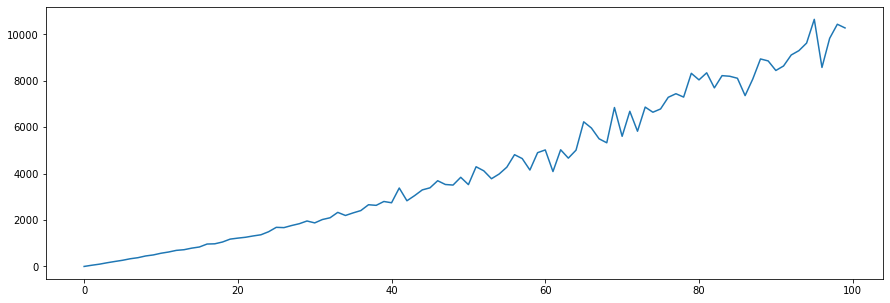

In [3]:
plt.figure(figsize=(15,5))
plt.plot(t, x)

### Re-inventando la rueda utilizando Regresion

De antemano sabemos que la funcion que buscamos corresponde a la ecuacion del movimiento rectilíneo uniformemente acelerado, 
<br><br>
<center>
$\begin{equation}
x_1 = x_0 + vt + \frac{1}{2}a t^2 
\end{equation}$
<center>

donde la posicion $x$ se encuentra en funcion del tiempo $t$, la velocidad $v$, y la aceleracion $a$.
    
    
En un problema de regresion tratamos de describir una variable continua a partir de uno o mas predictores. De esta forma, asumimos que existe una relacion entre ambas variables y, que es posible parametrizar su comportamiento definiendo asi, una funcion que describa el proceso. 

Desde la observacion de los datos podemos imaginar infinitas funciones

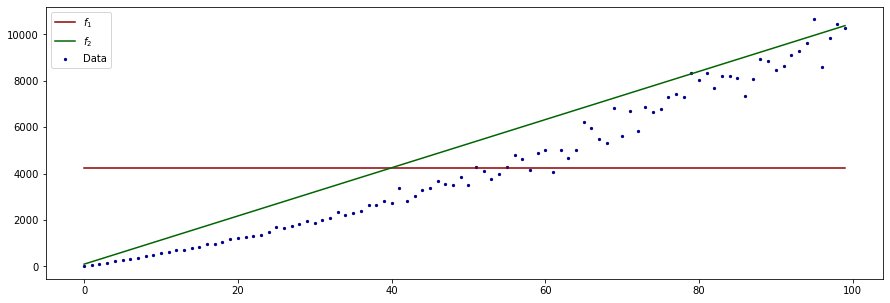

In [4]:
plt.figure(figsize=(15,5))

plt.scatter(t, x, s=5, label='Data', color='darkblue')

x_f1 = np.ones(len(t)) * x.mean()
plt.plot(t, x_f1, label='$f_1$', color='darkred')

x_f2 = (x[-1]-x[0])/(t[-1]-t[0])*(t - t[0]) + t[-1]
plt.plot(x_f2, label='$f_2$', color='darkgreen')


plt.legend()

#### De que forma podemos encontrar la funcion que mejor se adapta a los datos?

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

La primera funcion a considerar es el error medio cuadratico, la cual nos indica el error de nuestra funcion en terminos de la diferencia entre los valores esperados

In [6]:
print('MSE F_1: {:.2f}\nMSE F_2: {:.2f}'.format(mean_squared_error(x, x_f1, squared=True), 
                                                mean_squared_error(x, x_f2, squared=True)))

MSE F_1: 9293562.88
MSE F_2: 1274484.23


La metrica $R^2$ nos dice que tan distinto de la media es nuestra funcion. De esta forma: 

In [7]:
print('R2 F_1: {:.2f}\nR2 F_2: {:.2f}'.format(r2_score(x, x_f1), r2_score(x, x_f2)))

R2 F_1: 0.00
R2 F_2: 0.86


Ahora que tenemos una metrica de evaluacion entrenar ajustar algun modelo de aprendizaje automatico. Antes de ajustar nuestro modelo, debemos particionar el conjunto de datos:

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(t, x, test_size=0.33, random_state=42)

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
reg = LinearRegression()
reg = reg.fit(X_train[:,None], y_train)

In [12]:
x_pred = reg.predict(X_test[:,None])

Necesitamos ordenar la lista de valores, ya que el train_test_split aplica un shuffle sobre los datos y perdemos el orden temporal. 

In [13]:
indices = np.argsort(y_test)
X_test = X_test[indices]
y_test = y_test[indices]
x_pred = x_pred[indices]

Para comparar debemos evaluar las otras dos funciones con el mismo conjunto de test


In [14]:
x_f1 = np.ones(len(X_test)) * y_test.mean()
x_f2 = (y_test[-1]-y_test[0])/(X_test[-1]-X_test[0])*(X_test - X_test[0]) + X_test[-1]

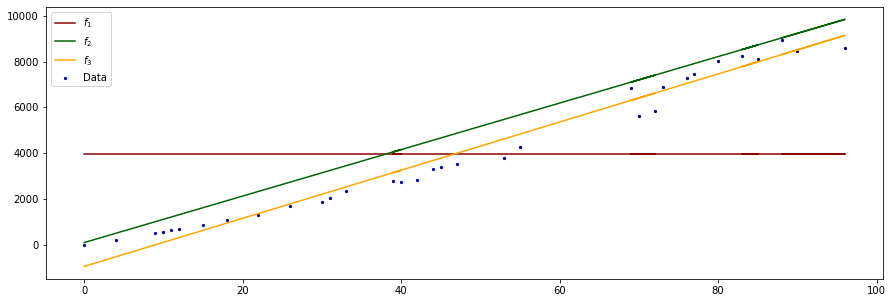

In [15]:
plt.figure(figsize=(15,5))

plt.scatter(X_test, y_test, s=5, label='Data', color='darkblue')

plt.plot(X_test, x_f1, label='$f_1$', color='darkred')
plt.plot(X_test, x_f2, label='$f_2$', color='darkgreen')
plt.plot(X_test, x_pred, label='$f_3$', color='orange')


plt.legend()

In [16]:
print('MSE F_1: {:.2f}\nMSE F_2: {:.2f}\nMSE F_3: {:.2f}'.format(mean_squared_error(y_test, x_f1, squared=True), 
                                                                 mean_squared_error(y_test, x_f2, squared=True),
                                                                 mean_squared_error(y_test, x_pred, squared=True)))

MSE F_1: 8661737.01
MSE F_2: 1015774.65
MSE F_3: 238832.84


La regresion lineal que ajustamos, obtiene el mejor MSE en comparacion con las otras funciones. Aun mas, podemos revisar los coeficientes 

In [17]:
print('m = {:.2f}\nb = {:.2f}'.format(reg.coef_[0], reg.intercept_))

m = 105.18
b = -955.16


En el caso de nuestra ecuacion:

$\begin{equation}
x = x_0 + 50t + \frac{1}{2}at^2
\end{equation}$
donde $a \sim \mathcal{N}(1, 2)$

Como podemos observar los valores no coinciden con los de nuestra ecuacion. Una razon tiene que ver con el grado del polinomio. En este caso estamos ajustando una regresion lineal sin embargo las relaciones de nuestra ecuacion no son lineales.

En particular, 
- La relacion entre la velocidad y el tiempo es lineal. Sin embargo, la velocidad tienen un ruido $\sim \mathcal{N}(1, 1)$ el cual no podemos ajustar (ya que es totalmente aleatorio)
- La aceleracion tiene una relacion no lineal (cuadratica) con el tiempo. En el ejercicio este valor fue capturado por el coeficiente de intercepcion en la ecuacion de la recta. Al igual que la velocidad la aceleracion es una variable aleatoria, la cual no tiene un valor fijo.

Asumiendo que la nuestros datos podrian tener una correlacion no lineal, trataremos de ajustar un modelo de regresion polinomial.

Lo primero que debemos considerar es **la matriz de diseno** ($D_x$). Debemos generar una matriz con los $M$ grados que necesitamos, tal que:

\begin{eqnarray}
    f(\boldsymbol{x}) & = & D_x\boldsymbol{m} + \epsilon \\ \\
     &=& \begin{bmatrix}
           1 & x_{0} & x_{0}^2 & ... & x_{0}^M \\
           1 & x_{1} & x_{1}^2 & ... & x_{1}^M\\
           \vdots & \vdots & \vdots & \ddots & \vdots \\
           1 & x_{N} & x_{N}^2 & ... & x_{N}^M
         \end{bmatrix} \begin{bmatrix} m_0 \\ m_1 \\ \cdots \\ m_D \end{bmatrix} + \epsilon \\\\
         y_i & = & \sum_{j=0}^M x_{ij}^jm_{j} + \epsilon_j
\end{eqnarray}

In [18]:
from sklearn.preprocessing import PolynomialFeatures

polyfeat = PolynomialFeatures(degree=3)
polyfeat = polyfeat.fit(X_train[:,None])

D_train = polyfeat.transform(X_train[:,None]) 
D_test = polyfeat.transform(X_test[:,None]) 

Ocuparemos el mismo modelo lineal, pero ahora utilizando la matriz de diseno como input

In [19]:
poly_reg = LinearRegression()
poly_reg = poly_reg.fit(D_train, y_train)

In [20]:
x_pred_poly = poly_reg.predict(D_test)

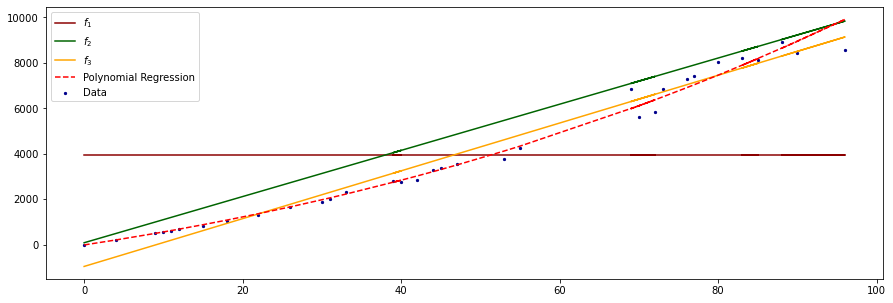

In [21]:
plt.figure(figsize=(15,5))

plt.scatter(X_test, y_test, s=5, label='Data', color='darkblue')

plt.plot(X_test, x_f1, label='$f_1$', color='darkred')
plt.plot(X_test, x_f2, label='$f_2$', color='darkgreen')
plt.plot(X_test, x_pred, label='$f_3$', color='orange')

plt.plot(X_test, x_pred_poly, '--r', label='Polynomial Regression')

plt.legend()

In [22]:
print('MSE F_1: {:.2f}\nMSE F_2: {:.2f}\nMSE F_3: {:.2f}\nMSE F_4: {:.2f}'.format(mean_squared_error(y_test, x_f1, squared=True), 
                                                                 mean_squared_error(y_test, x_f2, squared=True),
                                                                 mean_squared_error(y_test, x_pred, squared=True),
                                                                 mean_squared_error(y_test, x_pred_poly, squared=True)))

MSE F_1: 8661737.01
MSE F_2: 1015774.65
MSE F_3: 238832.84
MSE F_4: 137571.35


El error disminiuyo aun mas ya que ahora capturamos las relaciones no lineales entre las variables de entrada y de salida 

### Hasta cuando podemos seguir aumentando el grado de nuestro polinomio?

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1543418451/tradeoff_sevifm.png" alt="BiasVariance" width="500" height="600"> 

Para encontrar el optimo donde el modelo generaliza de la mejor manera posible podemos aplicar **regularizadores**. 

El termino regularizador se ubica en la funcion de costo (MSE) y penaliza en funcion de algun criterio. 

Lasso y Ridge son dos extensiones de la regresion lineal (o polinomial) donde:

\begin{eqnarray}
    \mathcal{L}_{ridge} &=& \text{MSE} + \lambda||\boldsymbol{w}||^2_2 \\
                        &=& \text{MSE} + \lambda\sum_jw_j^2
\end{eqnarray}
\begin{eqnarray}
    \mathcal{L}_{lasso} &=& \text{MSE} + \lambda||\boldsymbol{w}||_1 \\
                        &=& \text{MSE} + \lambda\sum_j|w_j|
\end{eqnarray}

en este caso $w$ son los pesos del modelo

In [23]:
from sklearn.linear_model import Lasso, Ridge

In [24]:
lineal = LinearRegression()
lineal.fit(D_train, y_train)

ridge = Ridge(alpha=0.1)
ridge.fit(D_train, y_train)

lasso = Lasso(alpha=0.1)
lasso.fit(D_train, y_train)

/home/cridonoso/miniconda3/envs/tf2/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3775117.184220508, tolerance: 63935.6667475683
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

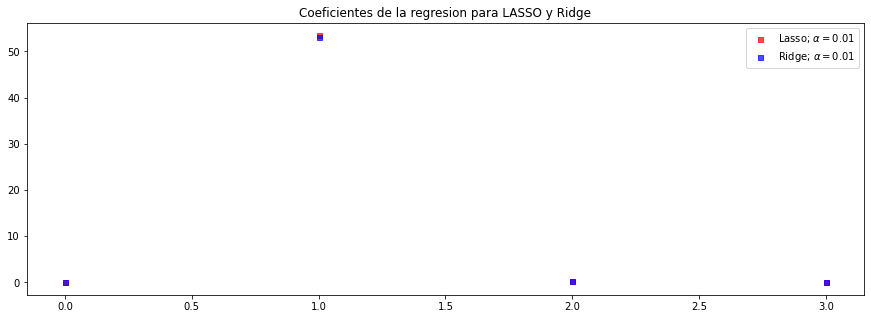

In [25]:
plt.figure(figsize=(15,5))
plt.plot(lasso.coef_ ,alpha=0.7, linestyle='none',
         marker='s',markersize=5,color='red',
         label=r'Lasso; $\alpha = 0.01$',zorder=7)

plt.plot(ridge.coef_ ,alpha=0.7, linestyle='none',
         marker='s',markersize=5,color='blue',
         label=r'Ridge; $\alpha = 0.01$',zorder=7)
plt.legend()
plt.title('Coeficientes de la regresion para LASSO y Ridge')
plt.show()

In [27]:
for model, name in zip([lineal, lasso, ridge], ['Lineal', 'Lasso', 'Ridge']):
    y_pred_test  = model.predict(D_test)
    y_pred  = model.predict(D_train)
    print('MSE {}: {:.2f} - {:.2f}'.format(name, mean_squared_error(y_train, y_pred, squared=True),
                                           mean_squared_error(y_test, y_pred_test, squared=True)))
     

MSE Lineal: 112846.40 - 137571.35
MSE Lasso: 112848.14 - 137843.36
MSE Ridge: 112846.40 - 137566.70
